In [1]:
import squidpy as sq
import scanpy as sc
import scvelo as scv
import numpy as np
import sys

import omnipath as op
op.clear_cache()

In [2]:
adata = sq.datasets.visium_hne_adata()
adata = adata[:,adata.var.highly_variable][:,0:1000].copy()
adata.var.index = np.char.upper(adata.var.index.values.astype(str))
adata.write("./../../test_adata.h5ad")

adata.obs["Cell"] = adata.obs.index
adata.obs[["Cell","cluster"]].to_csv("./../../test_meta.txt", sep="\t", index=False)

adata_df = adata.T.to_df()
adata_df.index.rename("Gene", inplace=True)
adata_df.to_csv("./../../test_adata.txt", sep="\t")

Run the cellphonedb analysis from command line

```
cellphonedb method statistical_analysis test_meta.txt test_adata.txt --output-path="./output" --iterations=1000 --threads=6 --threshold=0.1 --verbose --counts-data hgnc_symbol
```

In [3]:
# or alt. clone the cpdb repo and move this notebook into the repo's root
if False:
    sys.path.insert(0, "./cellphonedb/src/api_endpoints/terminal_api/method_terminal_api_endpoints/")
    from method_terminal_commands import statistical_analysis

    statistical_analysis("./../../test_meta.txt", "./../../test_adata.txt", iterations=1000, threads=6, threshold=0.1, verbose=True,
                         counts_data="gene_name")

In [4]:
adata.var

,gene_ids,feature_types,genome,mt,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,highly_variable,highly_variable_rank,means,variances,variances_norm
OPRK1,ENSMUSG00000025905,Gene Expression,mm10,False,324,0.171609,0.158378,87.991105,463.0,6.139884,324,True,1577.0,0.172247,0.303405,1.361687
ST18,ENSMUSG00000033740,Gene Expression,mm10,False,415,0.209785,0.190443,84.618236,566.0,6.340359,414,True,1364.0,0.209821,0.389900,1.432583
3110035E14RIK,ENSMUSG00000067879,Gene Expression,mm10,False,1816,3.743514,1.556778,32.690882,10100.0,9.220389,1814,True,223.0,3.756324,41.699811,3.539194
1700034P13RIK,ENSMUSG00000097893,Gene Expression,mm10,False,12,0.005189,0.005176,99.555226,14.0,2.708050,12,True,2418.0,0.005208,0.006672,1.185924
SGK3,ENSMUSG00000025915,Gene Expression,mm10,False,553,0.266123,0.235960,79.503336,718.0,6.577861,553,True,2679.0,0.267113,0.405736,1.148363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TMEM68,ENSMUSG00000028232,Gene Expression,mm10,False,1215,0.759081,0.564791,54.966642,2048.0,7.625107,1215,True,2881.0,0.761905,1.306148,1.126341
PENK,ENSMUSG00000045573,Gene Expression,mm10,False,1364,3.696812,1.546884,49.444033,9974.0,9.207837,1363,True,22.0,3.710193,131.140023,11.358528
FAM110B,ENSMUSG00000049119,Gene Expression,mm10,False,1462,1.007784,0.697031,45.811712,2719.0,7.908387,1462,True,3613.0,1.011533,1.770243,1.064102
SDCBP,ENSMUSG00000028249,Gene Expression,mm10,False,2376,3.751668,1.558496,11.934766,10122.0,9.222566,2373,True,1178.0,3.764509,18.005930,1.522757


In [5]:
adata.obs.cluster.cat.categories

Index(['Cortex_1', 'Cortex_2', 'Cortex_3', 'Cortex_4', 'Cortex_5',
       'Fiber_tract', 'Hippocampus', 'Hypothalamus_1', 'Hypothalamus_2',
       'Lateral_ventricle', 'Pyramidal_layer', 'Pyramidal_layer_dentate_gyrus',
       'Striatum', 'Thalamus_1', 'Thalamus_2'],
      dtype='object')

In [6]:
import re
import os
import pandas as pd
# datadir = 'out'
datadir = './../../output'
files = os.listdir(datadir)

# class cpdb:
#     def __init__(self, datadir):
#         files = os.listdir(datadir)
#         means = pd.read_csv([datadir +'/'+i for i in files if re.search('^means', i)][0])
#         pvalues = pd.read_csv([datadir +'/'+i for i in files if re.search('^pvalues', i)][0])
#         res2 = {}
#         cols = ()
#         rows = ()
#         for x in means.iloc[:, 11:].columns:
#             cols = cols + (tuple(x.split('|')),)
#             columns = pd.MultiIndex.from_tuples(cols, names=["cluster_1", "cluster_2"])

#         for x in means['interacting_pair']:
#             rows = rows + (tuple(x.split('_')),)
#         index = pd.MultiIndex.from_tuples(rows, names=["source", "target"])
#         means = pd.DataFrame(np.array(means.iloc[:,11:]), index = index, columns = columns)
#         pvalues = pd.DataFrame(np.array(pvalues.iloc[:,11:]), index = index, columns = columns)
#         pvalues[np.isclose(pvalues, 1.0)] = np.nan
#         pvalues[np.isclose(pvalues, 0.0)] = 0.001 # since i only did 1k iterations
#         self.means = means
#         self.pvalues = pvalues

# def CellPhoneResults(datadirs):
#     return(cpdb(datadirs).__dict__)
class cpdb:
    def __init__(self, datadir):
        files = os.listdir(datadir)
        means = pd.read_csv([datadir +'/'+i for i in files if re.search('^means', i)][0], sep = '\t')
        pvalues = pd.read_csv([datadir +'/'+i for i in files if re.search('^pvalues', i)][0], sep = '\t')
        res2 = {}
        cols = ()
        rows = ()
        for x in means.iloc[:, 11:].columns:
            cols = cols + (tuple(x.split('|')),)
            columns = pd.MultiIndex.from_tuples(cols, names=["cluster_1", "cluster_2"])
        for x in means['interacting_pair']:
            rows = rows + (tuple(x.split('_')),)
        index = pd.MultiIndex.from_tuples(rows, names=["source", "target"])
        means = pd.DataFrame(np.array(means.iloc[:,11:]), index = index, columns = columns)
        pvalues = pd.DataFrame(np.array(pvalues.iloc[:,11:]), index = index, columns = columns)
        pvalues[np.isclose(pvalues, 1.0)] = np.nan
        pvalues[np.isclose(pvalues, 0.0)] = 0.001 # since i only did 1k iterations
        self.means = means
        self.pvalues = pvalues

def CellPhoneResults(datadirs):
    return(cpdb(datadirs).__dict__)

In [7]:
original_cpdb_results = CellPhoneResults(datadir)

In [8]:
# test only with interactions from cellphonedb
res = sq.gr.ligrec(
    adata,
    n_perms=1000,
    cluster_key="cluster",
    copy=True,
    use_raw=False,
    interactions=list(original_cpdb_results['pvalues'].index),
    # interactions_params={'resources': 'CellPhoneDB'},
    threshold=0.1,
    n_jobs = 1)

  0%|          | 0/1000 [00:00<?, ?permutation/s]

Text(0.5, 0, 'theirs')

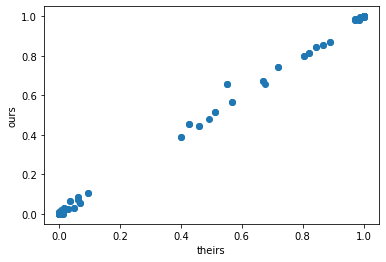

In [9]:
import matplotlib.pyplot as plt
np.testing.assert_allclose(original_cpdb_results['means'].values[0],
                           res['means'].values[0], rtol=1e-5, atol=1e-3)
plt.scatter(
    original_cpdb_results['pvalues'].fillna(1.0).values[0],
    res['pvalues'].fillna(1.0).values[0]
)
plt.ylabel("ours")
plt.xlabel("theirs")

In [10]:
original_cpdb_results['pvalues']

cluster_1     Cortex_1                                                  \
cluster_2     Cortex_1 Cortex_2 Cortex_3 Cortex_4 Cortex_5 Fiber_tract   
source target                                                            
L1CAM  L1CAM     0.677    0.017    0.012    0.036      NaN         NaN   
BDNF   SORT1     0.001    0.256    0.147    0.001      NaN       0.048   
       F11R        NaN      NaN      NaN      NaN    0.999       0.968   
EFNA3  EPHA4     0.001    0.031    0.826    0.001    0.960         NaN   
EFNA4  EPHA4       NaN      NaN      NaN      NaN      NaN         NaN   
PTPRC  MRC1        NaN      NaN      NaN      NaN      NaN         NaN   
SELL   CD34        NaN      NaN      NaN      NaN      NaN         NaN   
NPR1   NPPC        NaN      NaN      NaN      NaN      NaN         NaN   
QRFP   QRFPR       NaN      NaN      NaN      NaN      NaN         NaN   

cluster_1                                                                  \
cluster_2     Hippocampus Hypothalamus_1 Hypothalamus_2 Lateral_ventricle   
source target                                                               
L1CAM  L1CAM          NaN          0.001          0.568               NaN   
BDNF   SORT1          NaN            NaN            NaN               NaN   
       F11R         0.913          0.993          0.968             0.001   
EFNA3  EPHA4        0.007            NaN          0.984               NaN   
EFNA4  EPHA4          NaN            NaN            NaN               NaN   
PTPRC  MRC1           NaN            NaN            NaN               NaN   
SELL   CD34           NaN            NaN            NaN               NaN   
NPR1   NPPC           NaN            NaN            NaN               NaN   
QRFP   QRFPR          NaN            NaN            NaN               NaN   

cluster_1      ...  Thalamus_2                                            \
cluster_2      ... Fiber_tract Hippocampus Hypothalamus_1 Hypothalamus_2   
source target  ...                                                         
L1CAM  L1CAM   ...       0.984       0.890          0.001          0.001   
BDNF   SORT1   ...       0.001       0.917            NaN          0.965   
       F11R    ...       0.001       0.001          0.001          0.001   
EFNA3  EPHA4   ...         NaN       0.444            NaN            NaN   
EFNA4  EPHA4   ...         NaN         NaN            NaN            NaN   
PTPRC  MRC1    ...         NaN         NaN            NaN            NaN   
SELL   CD34    ...         NaN         NaN            NaN            NaN   
NPR1   NPPC    ...         NaN         NaN            NaN            NaN   
QRFP   QRFPR   ...         NaN         NaN            NaN            NaN   

cluster_1                                                                      \
cluster_2     Lateral_ventricle Pyramidal_layer Pyramidal_layer_dentate_gyrus   
source target                                                                   
L1CAM  L1CAM              0.719           0.001                         0.001   
BDNF   SORT1                NaN           0.001                         0.001   
       F11R               0.001           0.016                         0.038   
EFNA3  EPHA4                NaN           0.001                         0.001   
EFNA4  EPHA4                NaN             NaN                           NaN   
PTPRC  MRC1                 NaN             NaN                           NaN   
SELL   CD34                 NaN             NaN                           NaN   
NPR1   NPPC                 NaN             NaN                           NaN   
QRFP   QRFPR                NaN             NaN                           NaN   

cluster_1                                     
cluster_2     Striatum Thalamus_1 Thalamus_2  
source target                                 
L1CAM  L1CAM     0.001      0.001      0.001  
BDNF   SORT1     0.988      0.001        NaN  
       F11R      0.001      0.001      0.001  
EFNA3  EPHA4      

In [11]:
res['pvalues']

cluster_1     Cortex_1                                                  \
cluster_2     Cortex_1 Cortex_2 Cortex_3 Cortex_4 Cortex_5 Fiber_tract   
source target                                                            
L1CAM  L1CAM     0.658    0.029    0.017    0.067    1.000       1.000   
BDNF   SORT1     0.000    0.205    0.183    0.000    1.000       0.051   
       F11R      1.000    0.988    1.000    0.999    0.998       0.966   
EFNA3  EPHA4     0.000    0.044    0.852    0.000    0.939       1.000   
EFNA4  EPHA4       NaN      NaN      NaN      NaN      NaN         NaN   
PTPRC  MRC1        NaN      NaN      NaN      NaN      NaN         NaN   
SELL   CD34        NaN      NaN      NaN      NaN      NaN         NaN   
NPR1   NPPC        NaN      NaN      NaN      NaN      NaN         NaN   
QRFP   QRFPR       NaN      NaN      NaN      NaN      NaN         NaN   

cluster_1                                                                  \
cluster_2     Hippocampus Hypothalamus_1 Hypothalamus_2 Lateral_ventricle   
source target                                                               
L1CAM  L1CAM        1.000          0.000          0.565               1.0   
BDNF   SORT1        1.000          1.000          1.000               1.0   
       F11R         0.896          0.992          0.965               0.0   
EFNA3  EPHA4        0.004          1.000          0.986               1.0   
EFNA4  EPHA4          NaN            NaN            NaN               NaN   
PTPRC  MRC1           NaN            NaN            NaN               NaN   
SELL   CD34           NaN            NaN            NaN               NaN   
NPR1   NPPC           NaN            NaN            NaN               NaN   
QRFP   QRFPR          NaN            NaN            NaN               NaN   

cluster_1      ...  Thalamus_2                                            \
cluster_2      ... Fiber_tract Hippocampus Hypothalamus_1 Hypothalamus_2   
source target  ...                                                         
L1CAM  L1CAM   ...       0.981       0.868          0.000          0.000   
BDNF   SORT1   ...       0.000       0.902          1.000          0.977   
       F11R    ...       0.001       0.000          0.004          0.002   
EFNA3  EPHA4   ...       1.000       0.454          1.000          1.000   
EFNA4  EPHA4   ...         NaN         NaN            NaN            NaN   
PTPRC  MRC1    ...         NaN         NaN            NaN            NaN   
SELL   CD34    ...         NaN         NaN            NaN            NaN   
NPR1   NPPC    ...         NaN         NaN            NaN            NaN   
QRFP   QRFPR   ...         NaN         NaN            NaN            NaN   

cluster_1                                                                      \
cluster_2     Lateral_ventricle Pyramidal_layer Pyramidal_layer_dentate_gyrus   
source target                                                                   
L1CAM  L1CAM              0.744           0.000                         0.009   
BDNF   SORT1              0.999           0.000                         0.000   
       F11R               0.000           0.072                         0.054   
EFNA3  EPHA4              1.000           0.000                         0.000   
EFNA4  EPHA4                NaN             NaN                           NaN   
PTPRC  MRC1                 NaN             NaN                           NaN   
SELL   CD34                 NaN             NaN                           NaN   
NPR1   NPPC                 NaN             NaN                           NaN   
QRFP   QRFPR                NaN             NaN                           NaN   

cluster_1                                     
cluster_2     Striatum Thalamus_1 Thalamus_2  
source target                                 
L1CAM  L1CAM     0.000      0.000      0.000  
BDNF   SORT1     0.991      0.000      1.000  
       F11R      0.007      0.001      0.005  
EFNA3  EPHA4     1

In [12]:
res['pvalues'][('Pyramidal_layer', 'Hypothalamus_2')]

source  target
L1CAM   L1CAM     0.087
BDNF    SORT1     0.088
        F11R      0.000
EFNA3   EPHA4     0.000
EFNA4   EPHA4       NaN
PTPRC   MRC1        NaN
SELL    CD34        NaN
NPR1    NPPC        NaN
QRFP    QRFPR       NaN
Name: (Pyramidal_layer, Hypothalamus_2), dtype: Sparse[float64, nan]

In [13]:
original_cpdb_results['pvalues'][('Pyramidal_layer', 'Hypothalamus_2')]

source  target
L1CAM   L1CAM     0.064
BDNF    SORT1     0.055
        F11R      0.001
EFNA3   EPHA4     0.001
EFNA4   EPHA4       NaN
PTPRC   MRC1        NaN
SELL    CD34        NaN
NPR1    NPPC        NaN
QRFP    QRFPR       NaN
Name: (Pyramidal_layer, Hypothalamus_2), dtype: float64

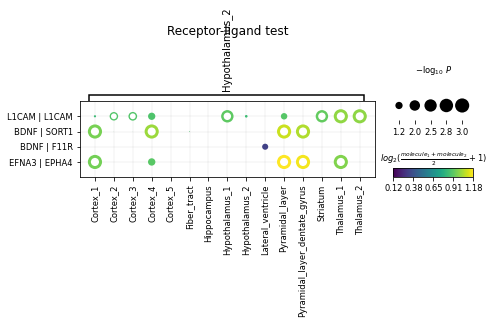

In [14]:
sq.pl.ligrec(res, source_groups="Hypothalamus_2", alpha=0.05)

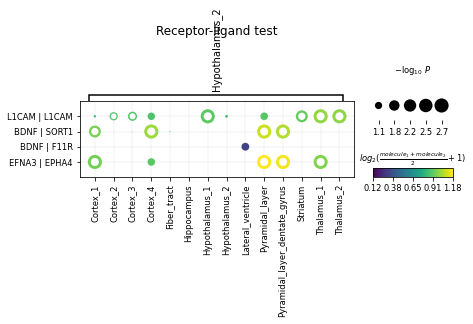

In [15]:
sq.pl.ligrec(original_cpdb_results, source_groups="Hypothalamus_2", alpha=0.05)

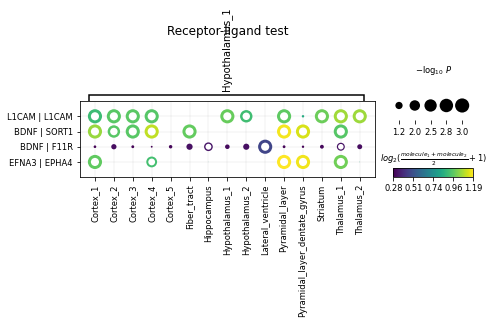

In [16]:
sq.pl.ligrec(res, source_groups="Hypothalamus_1", alpha=0.05,)

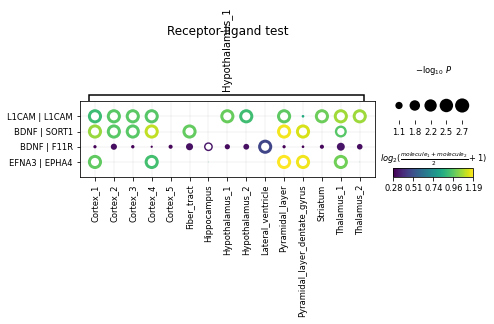

In [17]:
sq.pl.ligrec(original_cpdb_results, source_groups="Hypothalamus_1", alpha=0.05)

In [18]:
res["means"]

cluster_1      Cortex_1                                                      \
cluster_2      Cortex_1  Cortex_2  Cortex_3  Cortex_4  Cortex_5 Fiber_tract   
source target                                                                 
L1CAM  L1CAM   0.773069  0.838839  0.842468  0.832644  0.581665    0.516929   
BDNF   SORT1   1.015883  0.881324  0.880290  1.092248  0.696260    0.902551   
       F11R    0.163472  0.182316  0.164931  0.156002  0.170928    0.188023   
EFNA3  EPHA4   1.077704  0.855439  0.785505  1.010846  0.758300    0.642274   
EFNA4  EPHA4   0.737133  0.514868  0.444934  0.670275  0.417730    0.301704   
PTPRC  MRC1    0.030211  0.020259  0.017057  0.019621  0.049665    0.030503   
SELL   CD34    0.361327  0.129128  0.311417  0.482518  0.336528    0.153330   
NPR1   NPPC    0.121109  0.124179  0.101205  0.118840  0.038051    0.040891   
QRFP   QRFPR   0.000000  0.000000  0.000000  0.000000  0.000000    0.000000   

cluster_1                                                                  \
cluster_2     Hippocampus Hypothalamus_1 Hypothalamus_2 Lateral_ventricle   
source target                                                               
L1CAM  L1CAM     0.548824       0.873706       0.782518          0.558103   
BDNF   SORT1     0.723588       0.513706       0.696348          0.645853   
       F11R      0.199447       0.177750       0.187929          0.324174   
EFNA3  EPHA4     0.885688       0.615346       0.736073          0.597544   
EFNA4  EPHA4     0.545117       0.274776       0.395503          0.256974   
PTPRC  MRC1      0.029816       0.015817       0.032264          0.110817   
SELL   CD34      0.200712       0.091895       0.141655          0.141305   
NPR1   NPPC      0.045440       0.031957       0.039227          0.030974   
QRFP   QRFPR     0.000000       0.000000       0.000000          0.000000   

cluster_1      ...  Thalamus_2                                            \
cluster_2      ... Fiber_tract Hippocampus Hypothalamus_1 Hypothalamus_2   
source target  ...                                                         
L1CAM  L1CAM   ...    0.727635    0.759530       1.084412       0.993223   
BDNF   SORT1   ...    1.001637    0.822673       0.612792       0.795434   
       F11R    ...    0.287109    0.298532       0.276836       0.287014   
EFNA3  EPHA4   ...    0.572403    0.815816       0.545475       0.666202   
EFNA4  EPHA4   ...    0.304741    0.548155       0.277813       0.398540   
PTPRC  MRC1    ...    0.033156    0.032469       0.018470       0.034917   
SELL   CD34    ...    0.000000    0.000000       0.000000       0.000000   
NPR1   NPPC    ...    0.064393    0.068942       0.055458       0.062729   
QRFP   QRFPR   ...    0.000000    0.000000       0.000000       0.000000   

cluster_1                                                                      \
cluster_2     Lateral_ventricle Pyramidal_layer Pyramidal_layer_dentate_gyrus   
source target                                                                   
L1CAM  L1CAM           0.768808        1.062333                      0.897528   
BDNF   SORT1           0.744939        1.299939                      1.241043   
       F11R            0.423259        0.264269                      0.259190   
EFNA3  EPHA4           0.527673        1.334453                      1.304407   
EFNA4  EPHA4           0.260011        1.066791                      1.036746   
PTPRC  MRC1            0.113470        0.028583                      0.026466   
SELL   CD34            0.000000        0.000000                      0.000000   
NPR1   NPPC            0.054476        0.092886                      0.092535   
QRFP   QRFPR           0.000000        0.000000                      0.000000   

cluster_1                                      
cluster_2      Striatum Thalamus_1 Thalamus_2  
source target                                  
L1CAM  L1CAM   1.092243   1.198340   1.194480  
BDNF   SORT1   0.785659   0.972894   0.744104  


In [19]:
original_cpdb_results["means"]

cluster_1     Cortex_1                                                  \
cluster_2     Cortex_1 Cortex_2 Cortex_3 Cortex_4 Cortex_5 Fiber_tract   
source target                                                            
L1CAM  L1CAM     0.773    0.839    0.842    0.833    0.582       0.517   
BDNF   SORT1     1.016    0.881    0.880    1.092    0.696       0.903   
       F11R      0.163    0.182    0.165    0.156    0.171       0.188   
EFNA3  EPHA4     1.078    0.855    0.786    1.011    0.758       0.642   
EFNA4  EPHA4     0.737    0.515    0.445    0.670    0.418       0.302   
PTPRC  MRC1      0.030    0.020    0.017    0.020    0.050       0.031   
SELL   CD34      0.361    0.129    0.311    0.483    0.337       0.153   
NPR1   NPPC      0.121    0.124    0.101    0.119    0.038       0.041   
QRFP   QRFPR     0.000    0.000    0.000    0.000    0.000       0.000   

cluster_1                                                                  \
cluster_2     Hippocampus Hypothalamus_1 Hypothalamus_2 Lateral_ventricle   
source target                                                               
L1CAM  L1CAM        0.549          0.874          0.783             0.558   
BDNF   SORT1        0.724          0.514          0.696             0.646   
       F11R         0.199          0.178          0.188             0.324   
EFNA3  EPHA4        0.886          0.615          0.736             0.598   
EFNA4  EPHA4        0.545          0.275          0.396             0.257   
PTPRC  MRC1         0.030          0.016          0.032             0.111   
SELL   CD34         0.201          0.092          0.142             0.141   
NPR1   NPPC         0.045          0.032          0.039             0.031   
QRFP   QRFPR        0.000          0.000          0.000             0.000   

cluster_1      ...  Thalamus_2                                            \
cluster_2      ... Fiber_tract Hippocampus Hypothalamus_1 Hypothalamus_2   
source target  ...                                                         
L1CAM  L1CAM   ...       0.728       0.760          1.084          0.993   
BDNF   SORT1   ...       1.002       0.823          0.613          0.795   
       F11R    ...       0.287       0.299          0.277          0.287   
EFNA3  EPHA4   ...       0.572       0.816          0.545          0.666   
EFNA4  EPHA4   ...       0.305       0.548          0.278          0.399   
PTPRC  MRC1    ...       0.033       0.032          0.018          0.035   
SELL   CD34    ...       0.000       0.000          0.000          0.000   
NPR1   NPPC    ...       0.064       0.069          0.055          0.063   
QRFP   QRFPR   ...       0.000       0.000          0.000          0.000   

cluster_1                                                                      \
cluster_2     Lateral_ventricle Pyramidal_layer Pyramidal_layer_dentate_gyrus   
source target                                                                   
L1CAM  L1CAM              0.769           1.062                         0.898   
BDNF   SORT1              0.745           1.300                         1.241   
       F11R               0.423           0.264                         0.259   
EFNA3  EPHA4              0.528           1.334                         1.304   
EFNA4  EPHA4              0.260           1.067                         1.037   
PTPRC  MRC1               0.113           0.029                         0.026   
SELL   CD34               0.000           0.000                         0.000   
NPR1   NPPC               0.054           0.093                         0.093   
QRFP   QRFPR              0.000           0.000                         0.000   

cluster_1                                     
cluster_2     Striatum Thalamus_1 Thalamus_2  
source target                                 
L1CAM  L1CAM     1.092      1.198      1.194  
BDNF   SORT1     0.786      0.973      0.744  
       F11R      0.273      0.295      0.280  
EFNA3  EPHA4     0

In [20]:
# test with pypath cellphonedb
res = sq.gr.ligrec(
    adata,
    n_perms=1000,
    cluster_key="cluster",
    copy=True,
    use_raw=False,
#     interactions=list(original_cpdb_results['pvalues'].index),
    interactions_params={'resources': 'CellPhoneDB'},
    threshold=0.1,
    n_jobs = 6)

  0%|          | 0.00/422k [00:00<?, ?B/s]

  0%|          | 0.00/1.42M [00:00<?, ?B/s]

  0%|          | 0.00/2.63M [00:00<?, ?B/s]

  0%|          | 0/1000 [00:00<?, ?permutation/s]

In [21]:
original_cpdb_results['pvalues']

cluster_1     Cortex_1                                                  \
cluster_2     Cortex_1 Cortex_2 Cortex_3 Cortex_4 Cortex_5 Fiber_tract   
source target                                                            
L1CAM  L1CAM     0.677    0.017    0.012    0.036      NaN         NaN   
BDNF   SORT1     0.001    0.256    0.147    0.001      NaN       0.048   
       F11R        NaN      NaN      NaN      NaN    0.999       0.968   
EFNA3  EPHA4     0.001    0.031    0.826    0.001    0.960         NaN   
EFNA4  EPHA4       NaN      NaN      NaN      NaN      NaN         NaN   
PTPRC  MRC1        NaN      NaN      NaN      NaN      NaN         NaN   
SELL   CD34        NaN      NaN      NaN      NaN      NaN         NaN   
NPR1   NPPC        NaN      NaN      NaN      NaN      NaN         NaN   
QRFP   QRFPR       NaN      NaN      NaN      NaN      NaN         NaN   

cluster_1                                                                  \
cluster_2     Hippocampus Hypothalamus_1 Hypothalamus_2 Lateral_ventricle   
source target                                                               
L1CAM  L1CAM          NaN          0.001          0.568               NaN   
BDNF   SORT1          NaN            NaN            NaN               NaN   
       F11R         0.913          0.993          0.968             0.001   
EFNA3  EPHA4        0.007            NaN          0.984               NaN   
EFNA4  EPHA4          NaN            NaN            NaN               NaN   
PTPRC  MRC1           NaN            NaN            NaN               NaN   
SELL   CD34           NaN            NaN            NaN               NaN   
NPR1   NPPC           NaN            NaN            NaN               NaN   
QRFP   QRFPR          NaN            NaN            NaN               NaN   

cluster_1      ...  Thalamus_2                                            \
cluster_2      ... Fiber_tract Hippocampus Hypothalamus_1 Hypothalamus_2   
source target  ...                                                         
L1CAM  L1CAM   ...       0.984       0.890          0.001          0.001   
BDNF   SORT1   ...       0.001       0.917            NaN          0.965   
       F11R    ...       0.001       0.001          0.001          0.001   
EFNA3  EPHA4   ...         NaN       0.444            NaN            NaN   
EFNA4  EPHA4   ...         NaN         NaN            NaN            NaN   
PTPRC  MRC1    ...         NaN         NaN            NaN            NaN   
SELL   CD34    ...         NaN         NaN            NaN            NaN   
NPR1   NPPC    ...         NaN         NaN            NaN            NaN   
QRFP   QRFPR   ...         NaN         NaN            NaN            NaN   

cluster_1                                                                      \
cluster_2     Lateral_ventricle Pyramidal_layer Pyramidal_layer_dentate_gyrus   
source target                                                                   
L1CAM  L1CAM              0.719           0.001                         0.001   
BDNF   SORT1                NaN           0.001                         0.001   
       F11R               0.001           0.016                         0.038   
EFNA3  EPHA4                NaN           0.001                         0.001   
EFNA4  EPHA4                NaN             NaN                           NaN   
PTPRC  MRC1                 NaN             NaN                           NaN   
SELL   CD34                 NaN             NaN                           NaN   
NPR1   NPPC                 NaN             NaN                           NaN   
QRFP   QRFPR                NaN             NaN                           NaN   

cluster_1                                     
cluster_2     Striatum Thalamus_1 Thalamus_2  
source target                                 
L1CAM  L1CAM     0.001      0.001      0.001  
BDNF   SORT1     0.988      0.001        NaN  
       F11R      0.001      0.001      0.001  
EFNA3  EPHA4      

In [22]:
res['pvalues']

cluster_1     Cortex_1                                                  \
cluster_2     Cortex_1 Cortex_2 Cortex_3 Cortex_4 Cortex_5 Fiber_tract   
source target                                                            
EFNA3  EPHA4     0.000    0.042    0.842    0.000    0.938         1.0   
EFNA4  EPHA4       NaN      NaN      NaN      NaN      NaN         NaN   
NPPC   NPR1        NaN      NaN      NaN      NaN      NaN         0.0   
QRFP   QRFPR       NaN      NaN      NaN      NaN      NaN         NaN   
BMP7   ACVR2A    0.344    0.000    0.077    0.003    0.070         1.0   
IL7    IL2RG       NaN      NaN      NaN      NaN      NaN         NaN   
CD34   SELL        NaN      NaN      NaN      NaN      NaN         NaN   

cluster_1                                                                  \
cluster_2     Hippocampus Hypothalamus_1 Hypothalamus_2 Lateral_ventricle   
source target                                                               
EFNA3  EPHA4        0.003          1.000           0.99             1.000   
EFNA4  EPHA4          NaN            NaN            NaN               NaN   
NPPC   NPR1           NaN            NaN            NaN             0.000   
QRFP   QRFPR          NaN            NaN            NaN               NaN   
BMP7   ACVR2A       1.000          0.997           1.00             0.974   
IL7    IL2RG          NaN            NaN            NaN               NaN   
CD34   SELL           NaN            NaN            NaN               NaN   

cluster_1      ...  Thalamus_2                                            \
cluster_2      ... Fiber_tract Hippocampus Hypothalamus_1 Hypothalamus_2   
source target  ...                                                         
EFNA3  EPHA4   ...       1.000       0.432          1.000            1.0   
EFNA4  EPHA4   ...         NaN         NaN            NaN            NaN   
NPPC   NPR1    ...       0.009         NaN            NaN            NaN   
QRFP   QRFPR   ...         NaN         NaN            NaN            NaN   
BMP7   ACVR2A  ...       1.000       1.000          0.995            1.0   
IL7    IL2RG   ...         NaN         NaN            NaN            NaN   
CD34   SELL    ...         NaN         NaN            NaN            NaN   

cluster_1                                                                      \
cluster_2     Lateral_ventricle Pyramidal_layer Pyramidal_layer_dentate_gyrus   
source target                                                                   
EFNA3  EPHA4              1.000           0.000                         0.000   
EFNA4  EPHA4                NaN             NaN                           NaN   
NPPC   NPR1               0.000           0.167                         0.000   
QRFP   QRFPR                NaN             NaN                           NaN   
BMP7   ACVR2A             0.964           0.951                         0.048   
IL7    IL2RG                NaN             NaN                           NaN   
CD34   SELL                 NaN             NaN                           NaN   

cluster_1                                     
cluster_2     Striatum Thalamus_1 Thalamus_2  
source target                                 
EFNA3  EPHA4       1.0      0.000      0.378  
EFNA4  EPHA4       NaN        NaN        NaN  
NPPC   NPR1        NaN      0.002        NaN  
QRFP   QRFPR       NaN        NaN        NaN  
BMP7   ACVR2A      0.0      1.000      0.994  
IL7    IL2RG       NaN        NaN        NaN  
CD34   SELL        NaN        NaN        NaN  

[7 rows x 225 columns]

In [23]:
res['pvalues'][('Pyramidal_layer', 'Hypothalamus_2')]

source  target
EFNA3   EPHA4     0.0
EFNA4   EPHA4     NaN
NPPC    NPR1      NaN
QRFP    QRFPR     NaN
BMP7    ACVR2A    NaN
IL7     IL2RG     NaN
CD34    SELL      NaN
Name: (Pyramidal_layer, Hypothalamus_2), dtype: Sparse[float64, nan]

In [24]:
original_cpdb_results['pvalues'][('Pyramidal_layer', 'Hypothalamus_2')]

source  target
L1CAM   L1CAM     0.064
BDNF    SORT1     0.055
        F11R      0.001
EFNA3   EPHA4     0.001
EFNA4   EPHA4       NaN
PTPRC   MRC1        NaN
SELL    CD34        NaN
NPR1    NPPC        NaN
QRFP    QRFPR       NaN
Name: (Pyramidal_layer, Hypothalamus_2), dtype: float64

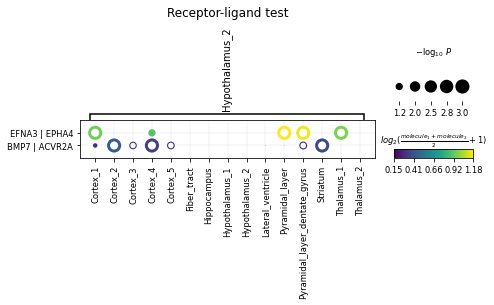

In [25]:
sq.pl.ligrec(res, source_groups="Hypothalamus_2", alpha=0.05)

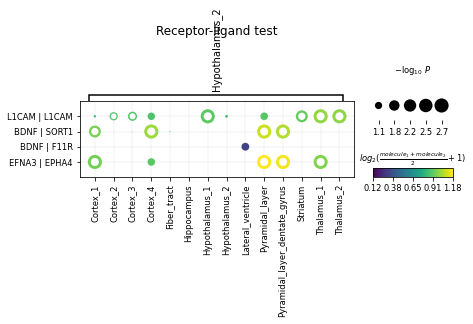

In [26]:
sq.pl.ligrec(original_cpdb_results, source_groups="Hypothalamus_2", alpha=0.05)

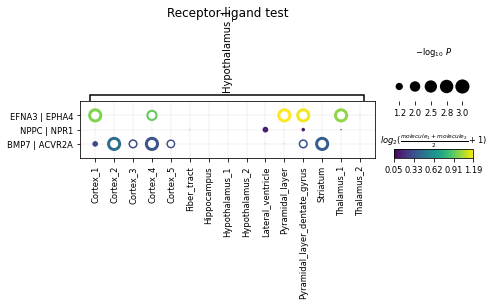

In [27]:
sq.pl.ligrec(res, source_groups="Hypothalamus_1", alpha=0.05,)

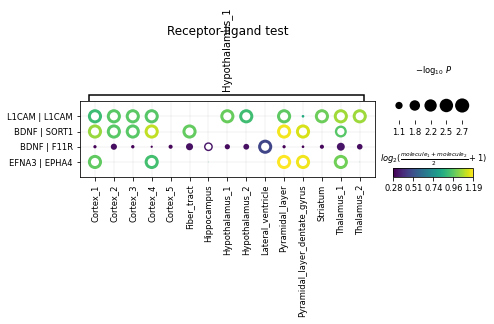

In [28]:
sq.pl.ligrec(original_cpdb_results, source_groups="Hypothalamus_1", alpha=0.05)

In [29]:
res["means"]

cluster_1      Cortex_1                                                      \
cluster_2      Cortex_1  Cortex_2  Cortex_3  Cortex_4  Cortex_5 Fiber_tract   
source target                                                                 
EFNA3  EPHA4   1.077704  0.855439  0.785505  1.010846  0.758300    0.642274   
EFNA4  EPHA4   0.737133  0.514868  0.444934  0.670275  0.417730    0.301704   
NPPC   NPR1    0.121109  0.130683  0.121975  0.124185  0.131934    0.166381   
QRFP   QRFPR   0.000000  0.000000  0.000000  0.000000  0.000000    0.000000   
BMP7   ACVR2A  0.213889  0.356070  0.231769  0.260584  0.238752    0.103640   
IL7    IL2RG   0.009020  0.005502  0.008354  0.006813  0.016460    0.010901   
CD34   SELL    0.361327  0.359584  0.361207  0.361571  0.000000    0.000000   

cluster_1                                                                  \
cluster_2     Hippocampus Hypothalamus_1 Hypothalamus_2 Lateral_ventricle   
source target                                                               
EFNA3  EPHA4     0.885688       0.615346       0.736073          0.597544   
EFNA4  EPHA4     0.545117       0.274776       0.395503          0.256974   
NPPC   NPR1      0.127520       0.130540       0.148737          0.197150   
QRFP   QRFPR     0.000000       0.000000       0.000000          0.000000   
BMP7   ACVR2A    0.106134       0.161225       0.122098          0.163308   
IL7    IL2RG     0.004781       0.009324       0.012746          0.043537   
CD34   SELL      0.367368       0.359757       0.361907          0.363525   

cluster_1      ...  Thalamus_2                                            \
cluster_2      ... Fiber_tract Hippocampus Hypothalamus_1 Hypothalamus_2   
source target  ...                                                         
EFNA3  EPHA4   ...    0.572403    0.815816       0.545475       0.666202   
EFNA4  EPHA4   ...    0.304741    0.548155       0.277813       0.398540   
NPPC   NPR1    ...    0.122519    0.083657       0.086677       0.104875   
QRFP   QRFPR   ...    0.000000    0.000000       0.000000       0.000000   
BMP7   ACVR2A  ...    0.106876    0.109369       0.164460       0.125334   
IL7    IL2RG   ...    0.016486    0.010366       0.014909       0.018330   
CD34   SELL    ...    0.000000    0.093788       0.086178       0.088327   

cluster_1                                                                      \
cluster_2     Lateral_ventricle Pyramidal_layer Pyramidal_layer_dentate_gyrus   
source target                                                                   
EFNA3  EPHA4           0.527673        1.334453                      1.304407   
EFNA4  EPHA4           0.260011        1.066791                      1.036746   
NPPC   NPR1            0.153287        0.109735                      0.143877   
QRFP   QRFPR           0.000000        0.000000                      0.000000   
BMP7   ACVR2A          0.166543        0.156306                      0.254942   
IL7    IL2RG           0.049122        0.010025                      0.018394   
CD34   SELL            0.089945        0.000000                      0.093067   

cluster_1                                      
cluster_2      Striatum Thalamus_1 Thalamus_2  
source target                                  
EFNA3  EPHA4   0.640321   1.042696   0.821057  
EFNA4  EPHA4   0.372659   0.775035   0.553395  
NPPC   NPR1    0.096979   0.128907   0.100748  
QRFP   QRFPR   0.000000   0.000000   0.000000  
BMP7   ACVR2A  0.293011   0.128185   0.163559  
IL7    IL2RG   0.000000   0.017810   0.018033  
CD34   SELL    0.089141   0.088072   0.000000  

[7 rows x 225 columns]

In [30]:
original_cpdb_results["means"]

cluster_1     Cortex_1                                                  \
cluster_2     Cortex_1 Cortex_2 Cortex_3 Cortex_4 Cortex_5 Fiber_tract   
source target                                                            
L1CAM  L1CAM     0.773    0.839    0.842    0.833    0.582       0.517   
BDNF   SORT1     1.016    0.881    0.880    1.092    0.696       0.903   
       F11R      0.163    0.182    0.165    0.156    0.171       0.188   
EFNA3  EPHA4     1.078    0.855    0.786    1.011    0.758       0.642   
EFNA4  EPHA4     0.737    0.515    0.445    0.670    0.418       0.302   
PTPRC  MRC1      0.030    0.020    0.017    0.020    0.050       0.031   
SELL   CD34      0.361    0.129    0.311    0.483    0.337       0.153   
NPR1   NPPC      0.121    0.124    0.101    0.119    0.038       0.041   
QRFP   QRFPR     0.000    0.000    0.000    0.000    0.000       0.000   

cluster_1                                                                  \
cluster_2     Hippocampus Hypothalamus_1 Hypothalamus_2 Lateral_ventricle   
source target                                                               
L1CAM  L1CAM        0.549          0.874          0.783             0.558   
BDNF   SORT1        0.724          0.514          0.696             0.646   
       F11R         0.199          0.178          0.188             0.324   
EFNA3  EPHA4        0.886          0.615          0.736             0.598   
EFNA4  EPHA4        0.545          0.275          0.396             0.257   
PTPRC  MRC1         0.030          0.016          0.032             0.111   
SELL   CD34         0.201          0.092          0.142             0.141   
NPR1   NPPC         0.045          0.032          0.039             0.031   
QRFP   QRFPR        0.000          0.000          0.000             0.000   

cluster_1      ...  Thalamus_2                                            \
cluster_2      ... Fiber_tract Hippocampus Hypothalamus_1 Hypothalamus_2   
source target  ...                                                         
L1CAM  L1CAM   ...       0.728       0.760          1.084          0.993   
BDNF   SORT1   ...       1.002       0.823          0.613          0.795   
       F11R    ...       0.287       0.299          0.277          0.287   
EFNA3  EPHA4   ...       0.572       0.816          0.545          0.666   
EFNA4  EPHA4   ...       0.305       0.548          0.278          0.399   
PTPRC  MRC1    ...       0.033       0.032          0.018          0.035   
SELL   CD34    ...       0.000       0.000          0.000          0.000   
NPR1   NPPC    ...       0.064       0.069          0.055          0.063   
QRFP   QRFPR   ...       0.000       0.000          0.000          0.000   

cluster_1                                                                      \
cluster_2     Lateral_ventricle Pyramidal_layer Pyramidal_layer_dentate_gyrus   
source target                                                                   
L1CAM  L1CAM              0.769           1.062                         0.898   
BDNF   SORT1              0.745           1.300                         1.241   
       F11R               0.423           0.264                         0.259   
EFNA3  EPHA4              0.528           1.334                         1.304   
EFNA4  EPHA4              0.260           1.067                         1.037   
PTPRC  MRC1               0.113           0.029                         0.026   
SELL   CD34               0.000           0.000                         0.000   
NPR1   NPPC               0.054           0.093                         0.093   
QRFP   QRFPR              0.000           0.000                         0.000   

cluster_1                                     
cluster_2     Striatum Thalamus_1 Thalamus_2  
source target                                 
L1CAM  L1CAM     1.092      1.198      1.194  
BDNF   SORT1     0.786      0.973      0.744  
       F11R      0.273      0.295      0.280  
EFNA3  EPHA4     0